In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.ndimage.filters import convolve1d

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import kalman_helper as kalman

https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation

Toy example:
- Robot en cuarto circular
- Quiere determinar su posicion
- Inicialemente puede estar en cualquiera de las N posibles posiciones diferentes
- Avanza de manera deterministica 1 posicion en cada paso
- La medicion de su posicion tiene error.

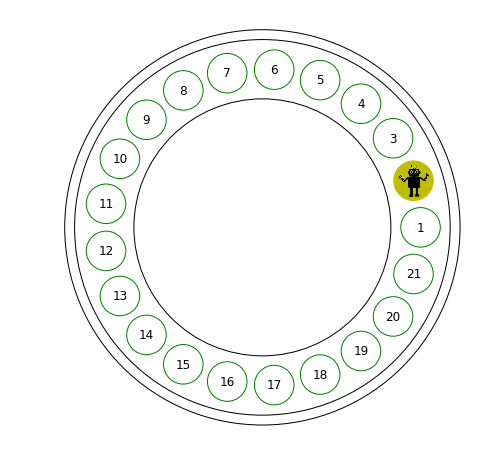

In [88]:
kalman.plot_robot_room(N = 21, loc = 2)

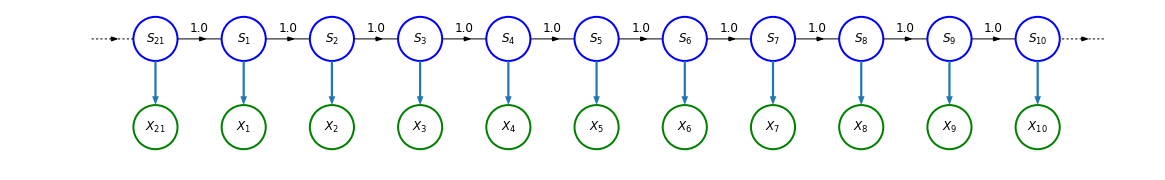

In [487]:
import draw_hmm as hmm
plt.figure(figsize = (20,10))
state = 1
hmm.draw_state(state = state, state_label = 21)
hmm.draw_transition(state1 = state, state2 = state+1, text = 1.0)
hmm.draw_observed(state = state, state_label = 21)
N_states = 10
for s in range(N_states):
    state = state + 1
    hmm.draw_state(state = state, state_label = state-1)
    #hmm.draw_self_transition(state = state)
    if s<(N_states-1):
        hmm.draw_transition(state1 = state, state2 = state+1, text = 1.0)
    hmm.draw_observed(state = state, state_label = state-1)
    
hmm.draw_infinite(state, state+1)
plt.axis('scaled')
plt.axis('off')

plt.show()

### Modelo
$S_k = S_{k-1} + 1$

$X_k = S_k + N$

- La $P(X_k|S_k)$ es el likelihood (Distribucion de observación, es lo que mido dado que estoy en un estado en particular)
- La $P(S_k)$ es la probabilidad apriori (distribucion antes de medir)
- La $P(S_k|X_k)$ es la probabilidad a posteriori (distribucion de S despues de realizar la medicion)

$P(S_k|X_k) = \frac{P(X_k|S_k)P(S_K)}{P(X_k)}$

$P(X_k) = \sum_i{P(X_k,S_i)} = \sum_i{P(X_k|S_i)P(S_i)}$



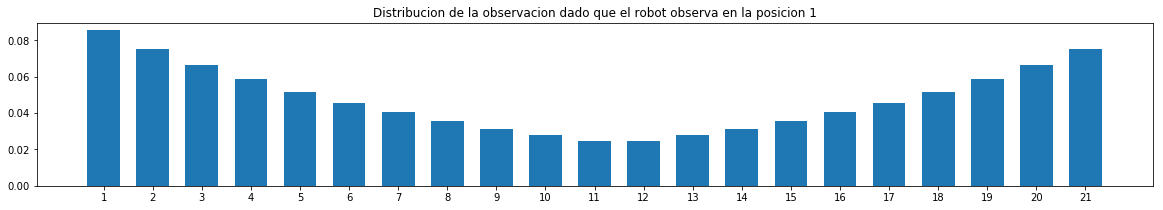

In [41]:
N = 21
indexes = np.linspace(1,N,N)
observed_dist_1 = kalman.get_observation_distribution(indexes, loc = 1, scale = scale)
kalman.plot_distribution(indexes, observed_dist_1, \
                         title = 'Distribucion de la observacion dado que el robot observa en la posicion 1')

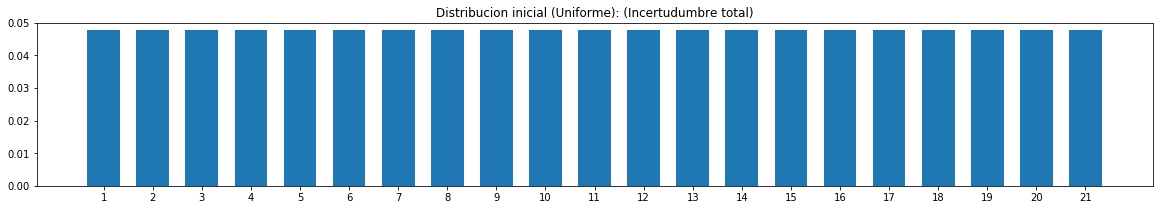

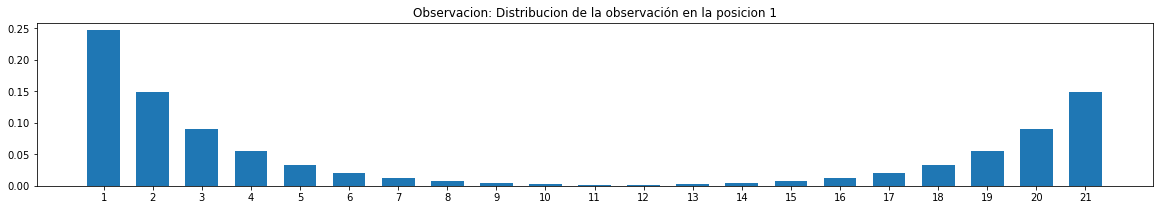

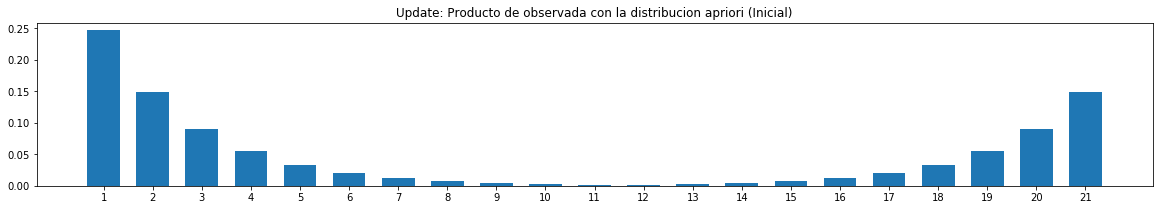

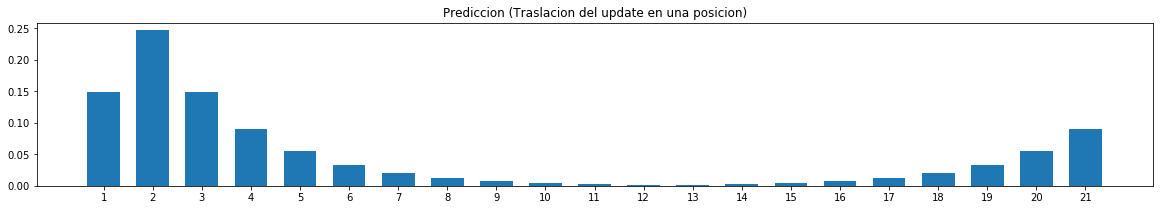

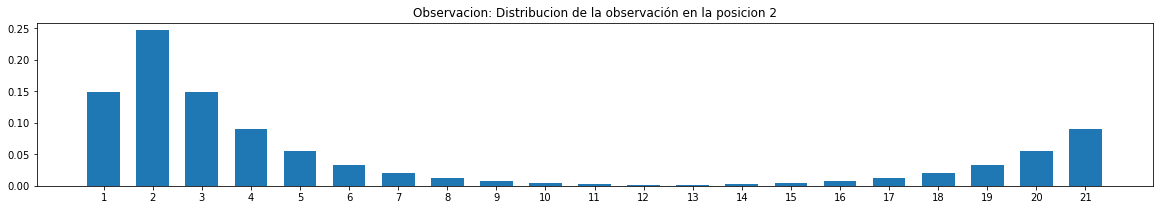

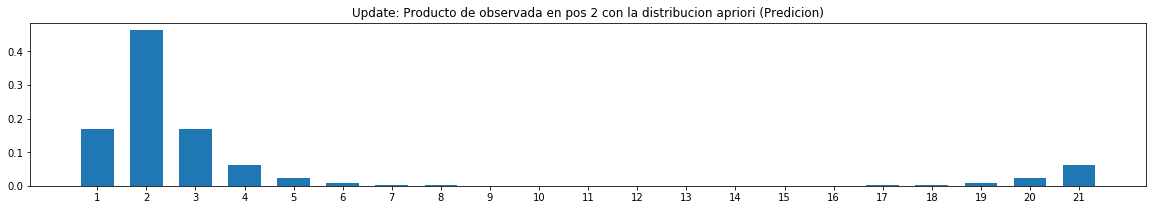

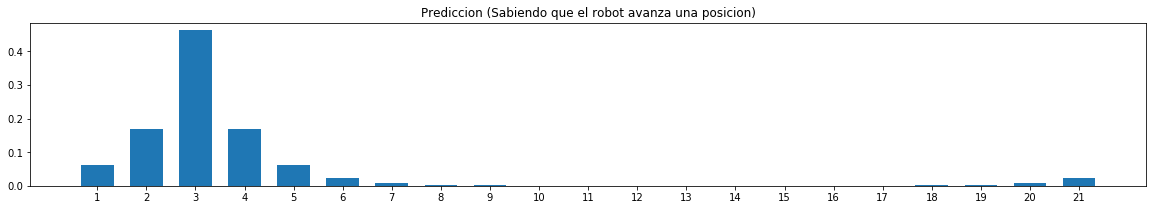

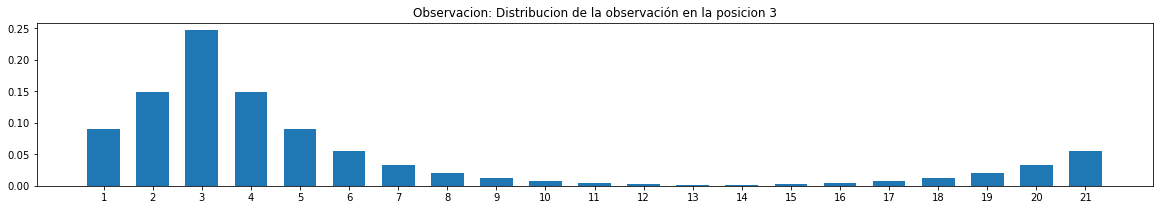

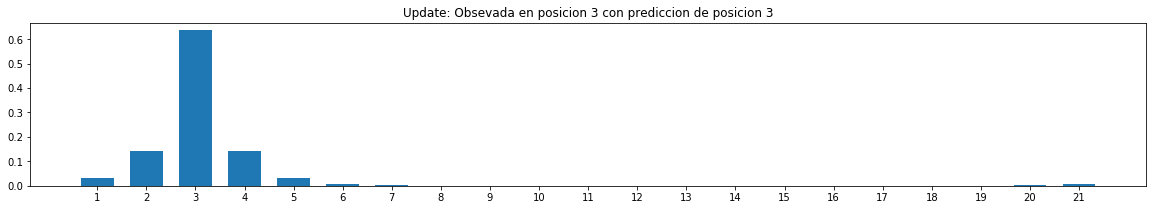

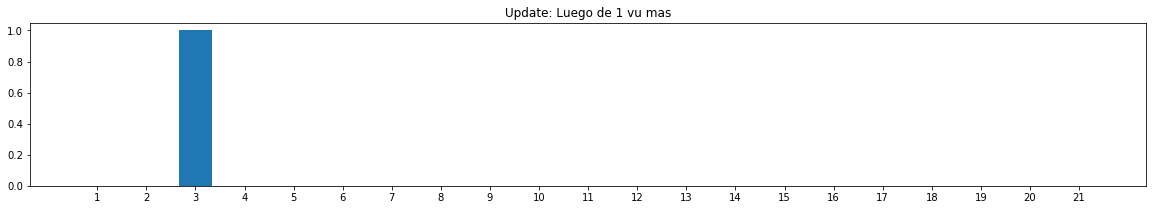

In [82]:
# Prediccion inicial
predicted_dist_1 = np.ones(N)/N
kalman.plot_distribution(indexes, predicted_dist_1, title = 'Distribucion inicial (Uniforme): (Incertudumbre total)')
loc = 1 #Ubicacion inicial
scale = 2 #Error de observacion

observed_dist_1 = kalman.get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_1, title = 'Observacion: Distribucion de la observación en la posicion 1')

updated_dist_1 = kalman.after_observation_distribution_update(predicted_dist_1, observed_dist_1)
kalman.plot_distribution(indexes, updated_dist_1,title = 'Update: Producto de observada con la distribucion apriori (Inicial)')

predicted_dist_2 = kalman.deterministic_next_step_distribution_prediction(updated_dist_1)
kalman.plot_distribution(indexes, predicted_dist_2, title = 'Prediccion (Traslacion del update en una posicion)')
loc = loc + 1
observed_dist_2 = kalman.get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_2, title = 'Observacion: Distribucion de la observación en la posicion 2')
updated_dist_2 = kalman.after_observation_distribution_update(predicted_dist_2, observed_dist_2)
kalman.plot_distribution(indexes, updated_dist_2, title = 'Update: Producto de observada en pos 2 con la distribucion apriori (Predicion)')

predicted_dist_3 = kalman.deterministic_next_step_distribution_prediction(updated_dist_2)
kalman.plot_distribution(indexes, predicted_dist_3, title = 'Prediccion (Sabiendo que el robot avanza una posicion)')
loc = loc + 1
observed_dist_3 = kalman.get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_3, title = 'Observacion: Distribucion de la observación en la posicion 3')
updated_dist_3 = kalman.after_observation_distribution_update(predicted_dist_3, observed_dist_3)
kalman.plot_distribution(indexes, updated_dist_3, title = 'Update: Obsevada en posicion 3 con prediccion de posicion 3')

updated_dist_n_1 = updated_dist_3
for i in range(1*N):
    predicted_dist_n = kalman.deterministic_next_step_distribution_prediction(updated_dist_n_1)
    loc = loc + 1
    observed_dist_n = kalman.get_observation_distribution(indexes, loc = loc, scale = scale)
    updated_dist_n_1 = kalman.after_observation_distribution_update(predicted_dist_n, observed_dist_n)
    
kalman.plot_distribution(indexes, updated_dist_n_1, title = 'Update: Luego de 1 vu mas')


Que pasa ahora si el movimiento del robot no es deterministico?
- Cada vez que el rebot se mueve tiene una distribucion de moverse a las distintas posiciones

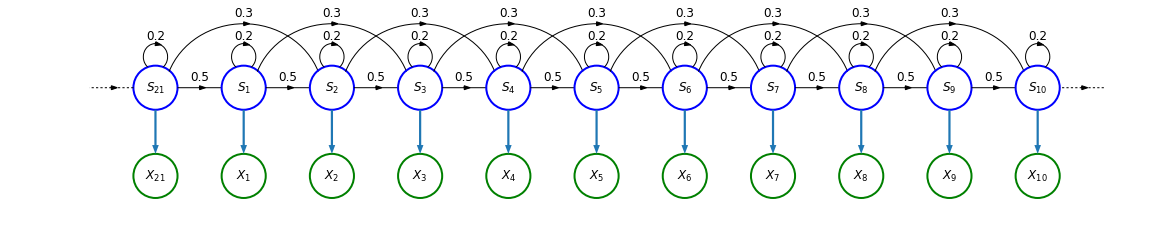

In [488]:
plt.figure(figsize = (20,10))
state = 1
stay_step_prob = 0.2
one_step_prob = 0.50
two_step_prob = 0.3
hmm.draw_state(state = state, state_label = 21)
hmm.draw_self_transition(state = state, text = stay_step_prob)
hmm.draw_transition(state1 = state, state2 = state+1, text = one_step_prob)
hmm.draw_transition(state1 = state, state2 = state+2, text = two_step_prob)
hmm.draw_observed(state = state, state_label = 21)
N_states = 10
for s in range(N_states):
    state = state + 1
    hmm.draw_state(state = state, state_label = state-1)
    
    hmm.draw_self_transition(state = state, text = stay_step_prob)
    if s<(N_states-1):
        hmm.draw_transition(state1 = state, state2 = state+1, text = one_step_prob)
    if s<(N_states-2):
        hmm.draw_transition(state1 = state, state2 = state+2, text = two_step_prob)
    hmm.draw_observed(state = state, state_label = state-1)
    
hmm.draw_infinite(state, state+1)
plt.axis('scaled')
plt.axis('off')

plt.show()

### Modelo
$S_k = S_{k-1} + D$

$X_k = S_k + N$

### Update (Bayes: producto de dos pdfs normalizado)

- La $P(X_k|S_k)$ es el likelihood (Distribucion de observación, es lo que mido dado que estoy en un estado en particular)
- La $P(S_k)$ es la probabilidad apriori (distribucion antes de medir)
- La $P(S_k|X_k)$ es la probabilidad a posteriori (distribucion de S despues de realizar la medicion)

$P(S_k|X_k) = \frac{P(X_k|S_k)P(S_K)}{P(X_k)}$

$P(X_k) = \sum_i{P(X_k,S_i)} = \sum_i{P(X_k|S_i)P(S_i)}$

### Prediction (Convolucion: Suma de V.A independientes)
Es la convolucion ya que es suma de dos variable aleatorias:
$S_{k-1} + D$


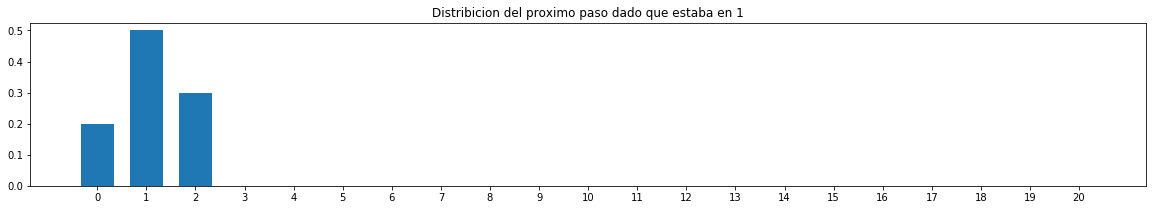

In [491]:
#scale_model = 1
#next_step_distribution = kalman.get_next_step_distribution(indexes, scale = scale_model)
next_step_distribution = np.zeros(N)
next_step_distribution[0] = stay_step_prob
next_step_distribution[1] = one_step_prob
next_step_distribution[2] = two_step_prob
kalman.plot_distribution(indexes-1, next_step_distribution, title = 'Distribicion del proximo paso dado que estaba en 1')

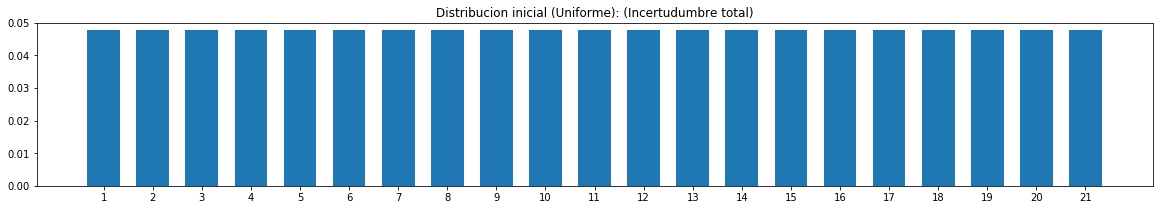

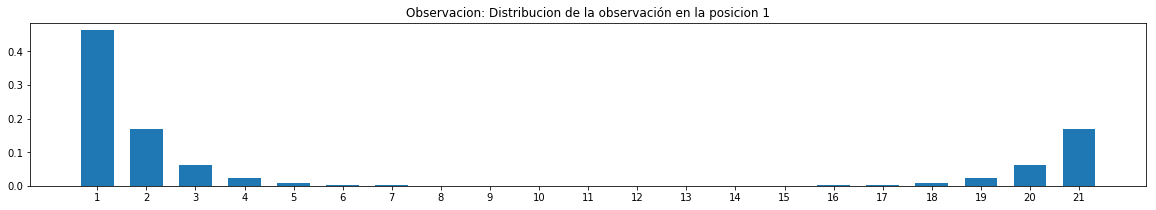

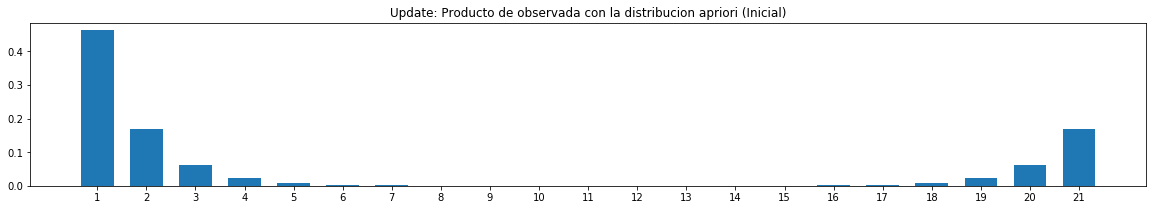

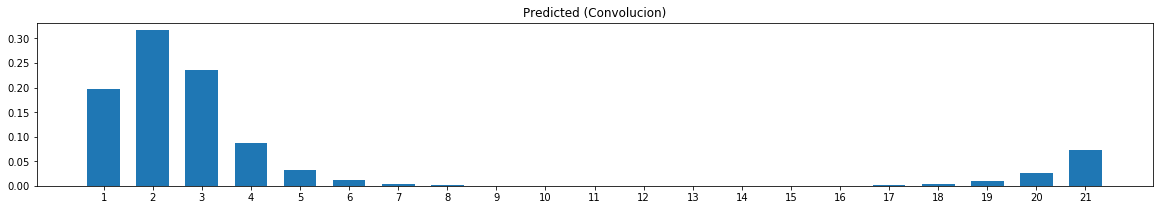

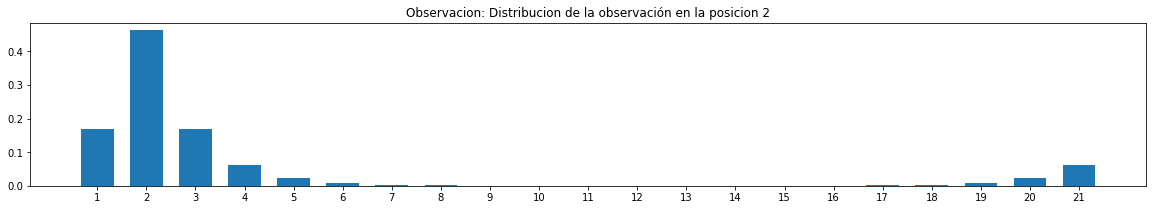

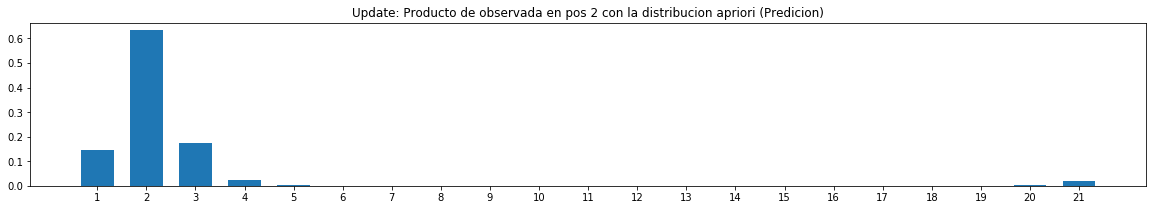

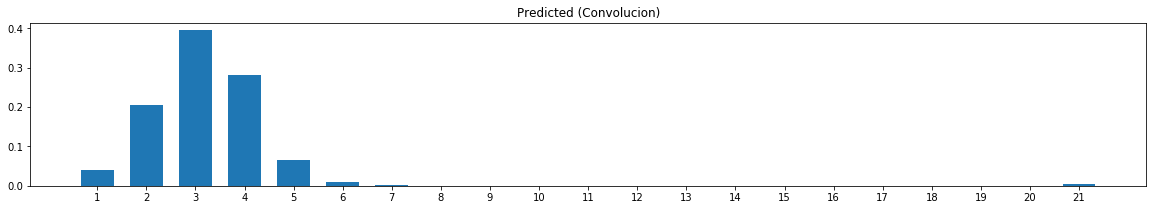

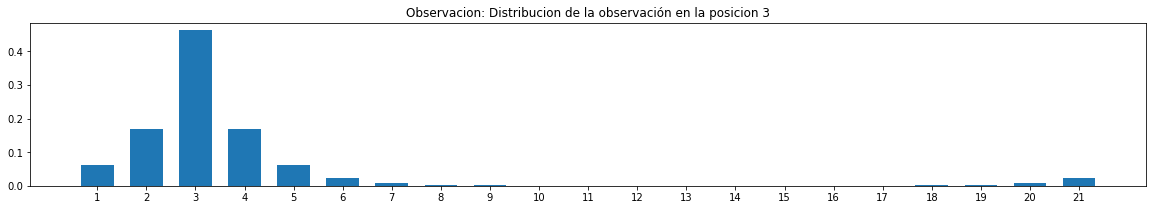

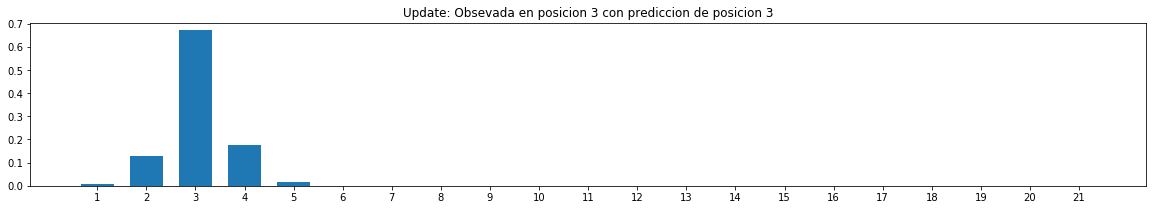

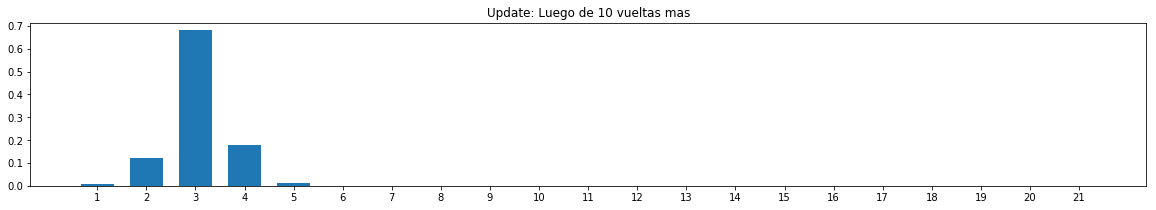

In [493]:
scale = 1 # observation
N = 21
indexes = np.linspace(1,N,N)
# Prediccion inicial
predicted_dist_1 = np.ones(N)/N
kalman.plot_distribution(indexes, predicted_dist_1, title = 'Distribucion inicial (Uniforme): (Incertudumbre total)')
loc = 1 #Ubicacion inicial

observed_dist_1 = kalman.get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_1, title = 'Observacion: Distribucion de la observación en la posicion 1')
updated_dist_1 = kalman.after_observation_distribution_update(predicted_dist_1, observed_dist_1)
kalman.plot_distribution(indexes, updated_dist_1,title = 'Update: Producto de observada con la distribucion apriori (Inicial)')

predicted_dist_2 = kalman.stochastic_next_step_distribution_prediction(updated_dist_1, next_step_distribution)
kalman.plot_distribution(indexes, predicted_dist_2,title = 'Predicted (Convolucion)')
loc = loc + 1
observed_dist_2 = kalman.get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_2, title = 'Observacion: Distribucion de la observación en la posicion 2')
updated_dist_2 = kalman.after_observation_distribution_update(predicted_dist_2, observed_dist_2)
kalman.plot_distribution(indexes, updated_dist_2, title = 'Update: Producto de observada en pos 2 con la distribucion apriori (Predicion)')

predicted_dist_3 = kalman.stochastic_next_step_distribution_prediction(updated_dist_2, next_step_distribution)
kalman.plot_distribution(indexes, predicted_dist_3, title = 'Predicted (Convolucion)')
loc = loc + 1
observed_dist_3 = kalman.get_observation_distribution(indexes, loc = loc, scale = scale)
kalman.plot_distribution(indexes, observed_dist_3, title = 'Observacion: Distribucion de la observación en la posicion 3')
updated_dist_3 = kalman.after_observation_distribution_update(predicted_dist_3, observed_dist_3)
kalman.plot_distribution(indexes, updated_dist_3, title = 'Update: Obsevada en posicion 3 con prediccion de posicion 3')

updated_dist_n_1 = updated_dist_3
for i in range(N*10):
    predicted_dist_n = kalman.stochastic_next_step_distribution_prediction(updated_dist_n_1, next_step_distribution)
    loc = loc + 1
    observed_dist_n = kalman.get_observation_distribution(indexes, loc = loc, scale = scale)
    updated_dist_n_1 = kalman.after_observation_distribution_update(predicted_dist_n, observed_dist_n)
    
kalman.plot_distribution(indexes, updated_dist_n_1, title = 'Update: Luego de 10 vueltas mas')
# agregar a las graficas la varianza y argmax

# Propiedades de las Gaussians
- ¿Que pasa con las medias y las varianzas cuando sumo (convolucion de pdfs) dos V.A?
- ¿Que pasa cuando multiplico dos pdfs gaussianas?

http://129.173.120.78/~kreplak/wordpress/wp-content/uploads/2010/12/gaussians_convolutions_lecture3.pdf

# Filtro de Kalman
- Si el error de medicion y del modelo son gaussianas
- estados infinitos

# Queremos estimar la posición de un movil en función del tiempo bajo las siguientes condiciones:
- Nuestra medicion tiene ruido
- Muestramos uniformemente
- Cada vez que muestramos, el movil avanzó cierta distancia, pero esa distancia no es una constante sino un V.A gaussiana.

# Observacion
La convolucion entre dos pdfs gaussianas es una gaussiana con media igual a la suma de las medias y varianzas igual a la suma de las varianzas. Esto es la suma de dos V.A independientes

In [494]:
def gaussian(x, mu, sig):
    return norm.pdf(x, loc = mu, scale = sig)
    #return np.exp(-np.power((x - mu)/sig, 2.)/2)/(np.sqrt(2.*np.pi)*sig)

def plot_gaussian(mu=0, sig= 1, points = 200, N = 2, marker=None, label = None, x = None, color = None, ax = None):
    if ax is None:
        f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (20,10))
    if x is None:
        x = np.linspace(mu-N*sig, mu+N*sig, points)
    y = gaussian(x, mu, sig)
    ax.plot(x,y, marker = marker, label = label, color = color)
    return x

In [495]:
def plot_kalman_process(mu, sig, points, measurements, motion):
    x = np.linspace(mu-2*10, mu+2*10, points)
    rows = int(np.ceil(len(measurements)/3))
    f, ax = plt.subplots(rows, 3, sharey=True, sharex=True, figsize = (20,10))
    ax = ax.flatten()
    for n in range(len(measurements)):
        label_data = '$\mu=%0.2f$  -  $\sigma^2=%0.2f$'%(mu,sig)
        plot_gaussian(mu=mu, sig= sig, points = points, N = 2, x=x, label = '(Initial) '+label_data, color = 'b', ax=ax[n])
        [mu, sig] = kalman.update(mu, sig, measurements[n], measurement_sig)
        label_data = '$\mu=%0.2f$  -  $\sigma^2=%0.2f$'%(mu,sig)
        plot_gaussian(mu=mu, sig= sig, points = points, N = 2, x=x, label = '(Update) '+label_data, color = 'r', ax=ax[n])
        #print('update:',[mu, sig])
        [mu, sig] = kalman.predict(mu, sig, motion[n], motion_sig)
        label_data = '$\mu=%0.2f$  -  $\sigma^2=%0.2f$'%(mu,sig)
        plot_gaussian(mu=mu, sig= sig, points = points, N = 2, x=x, label = '(Predict) '+label_data, color = 'y', ax=ax[n])
        #print('predict:',[mu, sig])
        ax[n].legend()
    plt.show()

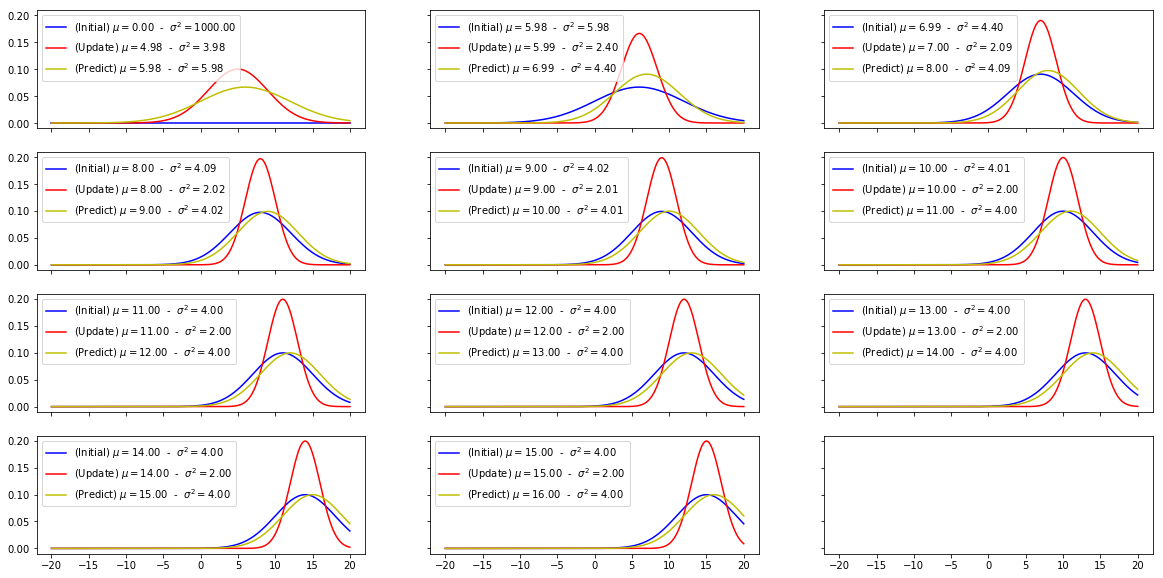

In [496]:
measurements = [5., 6., 7., 9., 10.]
motion = [1., 1., 2., 1., 1.]

first = 5
last = 15
measurements = list(np.linspace(first,last,last-first+1))
motion = list(np.ones(len(measurements)))

# Variance of measurement
measurement_sig = 4.
# Variance of action
motion_sig = 2.
# Initial mu
mu = 0.
# Initial variance
sig = 1000.
points = 200
plot_kalman_process(mu, sig, points, measurements, motion)

Interesante que cuando la medicion inicial es con varianza tendiendo a infinito 1000, es la convolucion con la medicion por lo que es como arrancar con la medicion.
Si la varianza es chica y la media no cumple con el modelo, el sistema tarda mas en converger

Linear Gaussian Markin Model = Kalman filter

In [ ]:
# measurement
sig_v = measurement_sig
# Variance of action
sig_w = motion_sig
a = 1
P_pred = (sig_w + sig_v*(a**2-1) +  np.sqrt((sig_w + sig_v*(a**2-1))**2 + 4*sig_w*sig_v))/2
P_obs = P_pred - sig_w
K = P_pred/(P_pred + sig_v)
p_n1 = (1-K)*P_pred + sig_w
print(P_pred, P_obs, K, p_n1)